In [5]:
import sys 
sys.path.append('../')
from tqdm import tqdm

import jax 
import jax.numpy as jnp 
import numpy as np
rng_np = np.random.default_rng(1)

from jaxlie import SE3, SO3
from jax.random import normal
from jax import grad, hessian, vmap, jit
from jax.lax import scan
from jax.scipy.stats import multivariate_normal as mvn

from functools import partial
import jax.random as jax_random
import matplotlib.pyplot as plt 
from IPython.display import clear_output
from plyfile import PlyData
import open3d as o3d 
import trimesh as tm
import trimesh
import time
import jaxopt
import polyscope as ps


import meshcat
import meshcat.geometry as mc_geom

from ergodic_mmd.aug_lagrange_jaxopt import AugmentedLagrangeSolver
# from ergodic_mmd.aug_lagrange_solver import AugmentedLagrangeSolver
from jax.scipy.stats import multivariate_normal as mvn


In [20]:
# jax.default_backend()
# jax.config.update("jax_default_device", jax.devices("cpu")[0])

# #runs on cpu
# long_vector = jnp.arange(int(1e7))
# %timeit jnp.dot(long_vector, long_vector).block_until_ready()

# jax.config.update("jax_default_device", jax.devices("gpu")[2])

'gpu'

In [8]:

mean1 = jnp.array([0.35, 0.38])
cov1 = jnp.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.5

mean2 = jnp.array([0.68, 0.25])
cov2 = jnp.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = jnp.array([0.56, 0.64])
cov3 = jnp.array([
    [0.008, 0.0],
    [0.0, 0.004]
])
w3 = 0.3

@jit
def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3)


# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], 100),
    np.linspace(0, L_list[1], 100)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / 99
dy = 1.0 / 99 

pdf_vals = pdf(grids)  # for visualizing the PDF
pdf_norm = np.sum(pdf_vals * pdf_vals) * dx * dy  # PDF norm for the kernel ergodic metric

# Sample from the spatial distribution
rng = jax.random.PRNGKey(0)
num_samples = 100
target_samples = jnp.vstack([
    jax.random.multivariate_normal(rng, mean=mean1, cov=cov1, shape=(int(num_samples*w1),)),
    jax.random.multivariate_normal(rng, mean=mean2, cov=cov2, shape=(int(num_samples*w2),)),
    jax.random.multivariate_normal(rng, mean=mean3, cov=cov3, shape=(int(num_samples*w3),))
])

points = target_samples
P_XI = vmap(pdf)(target_samples)
P_XI_NORM = jnp.sum(P_XI)
P_XI = P_XI/P_XI_NORM


In [9]:
def F_forward(x, u, dt):
    xp = x + dt * u
    return xp, x

forward_sim = lambda x0, u, dt: scan(partial(F_forward,dt=dt), x0, u)

def RBF_kernel(x, xp, h):
    return mvn.pdf(x=x, mean=xp, cov=jnp.diag(jnp.power(10.0, h)))
    # return jnp.exp(
    #     -jnp.exp(h)@(x-xp)**2
    # )

def create_kernel_matrix(kernel):
    return vmap(vmap(kernel, in_axes=(0, None, None)), in_axes=(None, 0, None))

KernelMatrix = create_kernel_matrix(RBF_kernel)
def emmd_loss(params, args):
    # X = params['X']
    U = params['U']
    X = forward_sim(args['x0'], U, args['dt'])[1]
    # X = jnp.vstack([X, args['x0']])

    T = X.shape[0]
    h = args['h']
    points    = args['points']
    P_XI      = args['P_XI']

    return np.sum(KernelMatrix(X, X, h))/(T*T) \
            - 2 * np.sum(P_XI @ KernelMatrix(X, points, h))/T + 1e-2*np.sum(U**2)

def fast_kernel_loss(params, args):
    # X = params['X']
    U = params['U']
    X = forward_sim(args['x0'], U, args['dt'])[1]
    # X = jnp.vstack([X, args['x0']])
    T = X.shape[0]
    h = args['h']
    points    = args['points']
    P_XI      = args['P_XI']

    return np.sum(KernelMatrix(X, X, h))/(T*T) \
            - 2 *np.sum(vmap(pdf)(X))/T + 1e-2*np.sum(U**2)

def eq_constr(params, args):
    # X = params['X']
    U = params['U']
    # q0 = args['q0']
    return jnp.zeros(1)
    # return jnp.vstack([
    #     X[0]-args['x0'],
    #     X[1:] - X[:-1] - args['dt'] * U[:-1],
    #     # X[-1]-args['x0']
    # ])
    # return jnp.hstack([X[0]-q0, X[-1]-q0])

def ineq_constr(params, args):
    # X = params['X']
    U = params['U']
    return jnp.zeros(1)
    # return jnp.vstack([
    #     U-1,
    #     -U-1
    # ])


In [10]:
# Optimize the kernel parameter
from jax.scipy.optimize import minimize 

d2_kernel = jit(grad(RBF_kernel, argnums=(1)))

# Define the kernel ergdic metric over samples
def samples_kernel_metric(theta, samples):
    val1 = vmap(pdf, in_axes=(0,))(samples)
    val2 = vmap(vmap(RBF_kernel, in_axes=(0,None,None)), in_axes=(None,0,None))(samples, samples, theta)
    return -2.0 * jnp.mean(val1) + jnp.mean(val2)

grad_samples_kernel_metric = grad(samples_kernel_metric, argnums=(1))

# Define the objective for optimizing kernel parameters
def parameter_opt_obj(theta, samples):
    dvec = grad_samples_kernel_metric(theta, samples)
    return jnp.sum(jnp.square(dvec))  

theta_sol = minimize(parameter_opt_obj, x0=jnp.array([-3.0, -3.0]), args=(target_samples,), method='bfgs')
opt_theta = theta_sol.x
print('optimal kernel parameter: ', opt_theta)

optimal kernel parameter:  [-2.57459526 -2.58787926]


In [11]:
# h = 0.0025
args = {
        'h' : opt_theta, 
        'points' : points, 
        'P_XI' : P_XI,
        'dt' : 0.1,
        'x0' : jnp.array([0.61,0.6])
}


In [12]:
T = 100
X = jnp.linspace(args['x0'], args['x0']+0.1, num=T)
X = jnp.array([
    np.linspace(0.0, 0.3, T) * np.cos(np.linspace(0.0, 2*np.pi, T)),
    np.linspace(0.0, 0.3, T) * np.sin(np.linspace(0.0, 2*np.pi, T))
]).T

# generate a spiral trajectory as the initial control
# temp_x_traj = np.array([
#     np.linspace(0.0, 0.3, tsteps+1) * np.cos(np.linspace(0.0, 2*np.pi, tsteps+1)),
#     np.linspace(0.0, 0.3, tsteps+1) * np.sin(np.linspace(0.0, 2*np.pi, tsteps+1))
# ]).T
U = (X[1:, :] - X[:-1, :]) / args['dt']

# U = jnp.zeros((T, 2))

params = {'U': U}

emmd_solver = AugmentedLagrangeSolver(params, emmd_loss, eq_constr, ineq_constr, args=args, c=.1)
fast_kernel_solver = AugmentedLagrangeSolver(params, fast_kernel_loss, eq_constr, ineq_constr, args=args, c=.1)

# solver = AugmentedLagrangeSolver(
#     params, emmd_loss, eq_constr, ineq_constr, 
#     step_size=1e-3,
#     args=args)
# 

In [13]:
fast_kernel_solver.solve(max_iter=15_000, eps=1e-3)
fast_kernel_sol = fast_kernel_solver.solution

0 9.705797975529778
1 5.512520360522762
2 5.845044916575081
3 4.33541230415598
4 5.16349075986108
5 4.01361168933305
6 4.1222415441962745
7 3.9325672944799708
8 3.4030044511016313
9 3.0762462107070774
10 4.425715656816842
11 2.872741970004407
12 2.8872871671304
13 4.692273680423148
14 2.5336375941140155
15 2.364255921634502
16 2.340823134491727
17 3.8056189871778012
18 2.0828812936654097
19 1.954688617141088
20 2.734689184053702
21 2.2249168237248647
22 1.6469132828948156
23 1.7394915389876884
24 1.7136099282181765
25 1.5742975783720905
26 1.4130152466547679
27 1.4543767409118484
28 1.446389454395141
29 1.509412392680313
30 1.5658178832574383
31 1.4152811755005315
32 1.2721515836330266
33 2.0412664656610744
34 1.4782045632650849
35 1.1573258646307638
36 1.1877629176583746
37 1.1365803679233346
38 1.1318845786730916
39 1.1264725139827239
40 1.1365634717637654
41 1.0383688150457784
42 0.9094661672400899
43 0.9293226107775949
44 0.9181249467723022
45 0.9445810341393178
46 0.87633382667548

In [71]:
emmd_solver.solve(max_iter=15_000, eps=1e-3)
emmd_sol = emmd_solver.solution

0 10.795480646283675
1 9.012817641031626
2 7.106658918943865
3 6.429301951787205
4 5.810352675536798
5 5.670321065802119
6 4.407000624653125
7 4.202588383993496
8 5.559689261010677
9 3.4003484207607917
10 4.308250109168655
11 2.908791555143512
12 2.697593626108151
13 2.702768011610769
14 2.232635119193089
15 2.035811619705025
16 2.43532671864586
17 2.0825732877528713
18 1.621961011747829
19 1.594888482424241
20 2.314328460174722
21 1.8774071436673283
22 1.3814986796445536
23 1.4942139077230836
24 1.480258575188318
25 1.380455856877437
26 1.270325194499565
27 1.9063201909264194
28 1.4162779382028854
29 1.192401564850349
30 1.7470265772195601
31 1.3905067752756521
32 1.1679716565558247
33 1.8656321831757807
34 1.5498169142252938
35 1.2201980631668918
36 1.2885042864418208
37 1.8872915525499827
38 1.6970817388569617
39 1.3446730881815503
40 1.3940427448885035
41 1.9670270753058954
42 1.7490575674738078
43 1.2781751333014906
44 1.2465572312585025
45 1.7372733156994675
46 1.5160895817497162

In [53]:
import pickle as pkl

smc_traj = pkl.load(open('../data/ergodic.pkl','rb'))
hedac_traj = pkl.load(open('../data/traj.pkl','rb'))

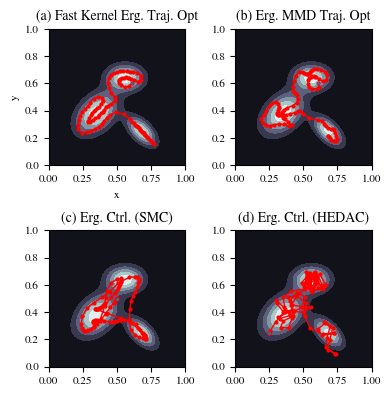

In [103]:
# Iterative trajectory optimization for ergodic control
from IPython import display

plt.rcParams["font.family"] = "freeserif"
plt.rcParams.update({'font.size': 8})

loss_list = []

fig, axes = plt.subplots(2, 2, figsize=(4,4), tight_layout=True)

# for iter in tqdm(range(100)):

# solver.solve(max_iter=10, eps=1e-3, alpha=1.00001)
# loss_list.append(emmd_loss(sol, args))

U = fast_kernel_sol['U']
X = forward_sim(args['x0'], U, args['dt'])[1]

# visualize every 10 iterations
# if (iter+1) % 10 == 0:
ax1 = axes[0,0]
ax1.cla()
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlim(0.0, L_list[0])
ax1.set_ylim(0.0, L_list[1])
ax1.set_title('(a) Fast Kernel Erg. Traj. Opt', fontsize=10)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='bone')
# ax1.plot([x0[0], x_traj[0,0]], [x0[1], x_traj[0,1]], linestyle='-', linewidth=2, color='k', alpha=1.0)
ax1.plot(X[:,0], X[:,1], linestyle='-', marker='o', color='r', linewidth=1, markersize=2, alpha=1.0, label='Optimized trajectory')
ax1.plot(args['x0'][0], args['x0'][1], linestyle='', marker='o', markersize=1, color='C0', alpha=1.0, label='Initial state')
# ax1.legend(loc=1)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)


ax2 = axes[0,1]
U = emmd_sol['U']
X = forward_sim(args['x0'], U, args['dt'])[1]
ax2.cla()
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim(0.0, L_list[0])
ax2.set_ylim(0.0, L_list[1])
ax2.set_title('(b) Erg. MMD Traj. Opt',fontsize=10)
# ax2.set_xlabel('x')
# ax2.set_ylabel('y')
ax2.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='bone')
# ax1.plot([x0[0], x_traj[0,0]], [x0[1], x_traj[0,1]], linestyle='-', linewidth=2, color='k', alpha=1.0)
ax2.plot(X[:,0], X[:,1], linestyle='-', marker='o', color='r', linewidth=1, markersize=2, alpha=1.0, label='Optimized trajectory')
ax2.plot(args['x0'][0], args['x0'][1], linestyle='', marker='o', markersize=1, color='C0', alpha=1.0, label='Initial state')
# ax2.legend(loc=1)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

ax2 = axes[1,0]
smc_traj = pkl.load(open('../data/ergodic.pkl','rb'))

ax2.cla()
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim(0.0, L_list[0])
ax2.set_ylim(0.0, L_list[1])
ax2.set_title('(c) Erg. Ctrl. (SMC)', fontsize=10)
# ax2.set_xlabel('x')
# ax2.set_ylabel('y')
ax2.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='bone')
# ax1.plot([x0[0], x_traj[0,0]], [x0[1], x_traj[0,1]], linestyle='-', linewidth=2, color='k', alpha=1.0)
ax2.plot(smc_traj[:,0], smc_traj[:,1], linestyle='-', marker='o', color='r', linewidth=1, markersize=2, alpha=1.0, label='Optimized trajectory')
ax2.plot(smc_traj[0], smc_traj[1], linestyle='', marker='o', markersize=1, color='C0', alpha=1.0, label='Initial state')
# ax2.legend(loc=1)
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)


ax2 = axes[1,1]
hedac_traj = pkl.load(open('../data/hedac.pkl','rb'))/100

ax2.cla()
ax2.set_aspect('equal', adjustable='box')
ax2.set_xlim(0.0, L_list[0])
ax2.set_ylim(0.0, L_list[1])
ax2.set_title('(d) Erg. Ctrl. (HEDAC)', fontsize=10)
# ax2.set_xlabel('x')
# ax2.set_ylabel('y')
ax2.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='bone')
# ax1.plot([x0[0], x_traj[0,0]], [x0[1], x_traj[0,1]], linestyle='-', linewidth=2, color='k', alpha=1.0)
ax2.plot(hedac_traj[::10,0], hedac_traj[::10,1], linestyle='-', marker='o', color='r', linewidth=1, markersize=2, alpha=1.0, label='Optimized trajectory')
ax2.plot(hedac_traj[0], hedac_traj[1], linestyle='', marker='o', markersize=1, color='C0', alpha=1.0, label='Initial state')
# ax2.legend(loc=1)

#     display.clear_output(wait=True)
#     display.display(fig)

# display.clear_output(wait=True)
# plt.show()
# plt.close()
plt.savefig('../figures/kernel_methods_comparison.svg')


# Numerical computation of metric

In [14]:
@jit
def emmd_loss(params, args):
    X = params['X']
    # U = params['U']
    # X = forward_sim(args['x0'], U, args['dt'])[1]
    # X = jnp.vstack([X, args['x0']])

    T = X.shape[0]
    h = args['h']
    points    = args['points']
    P_XI      = args['P_XI']

    return np.sum(KernelMatrix(X, X, h))/(T*T) \
            - 2 * np.sum(P_XI @ KernelMatrix(X, points, h))/T

pdf = lambda x: 1.0

@jit
def fast_kernel_loss(params, args):
    X = params['X']
    # U = params['U']
    # X = forward_sim(args['x0'], U, args['dt'])[1]
    # X = jnp.vstack([X, args['x0']])
    T = X.shape[0]
    h = args['h']
    # points    = args['points']
    # P_XI      = args['P_XI']

    return np.sum(KernelMatrix(X, X, h))/(T*T) \
            - 2 *np.sum(vmap(pdf)(X))/T 

In [15]:
# Sample from the spatial distribution
rng = jax.random.PRNGKey(0)
num_samples = 100
n_dim = 2

key, subkey = jax.random.split(rng, 2)
points = jax.random.uniform(subkey, shape=(num_samples, n_dim))

P_XI = jnp.ones(num_samples)
P_XI_NORM = jnp.sum(P_XI)
P_XI = P_XI/P_XI_NORM

args = {
        'h' : jnp.ones(n_dim), 
        'points' : points, 
        'P_XI' : P_XI,
        'dt' : 0.1,
}

T = 100
X = jnp.linspace(-jnp.ones(n_dim), jnp.ones(n_dim), num=T)

params = {'X': X}


## time scale analysis

In [29]:
# Sample from the spatial distribution
rng = jax.random.PRNGKey(0)
num_samples = 100
n_dim = 2

key, subkey = jax.random.split(rng, 2)
points = jax.random.uniform(subkey, shape=(num_samples, n_dim))

P_XI = jnp.ones(num_samples)
P_XI_NORM = jnp.sum(P_XI)
P_XI = P_XI/P_XI_NORM

args = {
        'h' : jnp.ones(n_dim), 
        'points' : points, 
        'P_XI' : P_XI,
        'dt' : 0.1,
}

T = 100
X = jnp.linspace(-jnp.ones(n_dim), jnp.ones(n_dim), num=T)

params = {'X': X}

Ts = [100, 1000, 10_000]
log = {
    'emmd' : {'mean' : [], 
            'std' : []},
    'fast_kernel' : {'mean' : [], 
            'std' : []}
}
for T in Ts: 
    X = jnp.linspace(-jnp.ones(n_dim), jnp.ones(n_dim), num=T)

    params = {'X': X}
    emmd_loss(params, args)
    fast_kernel_loss(params, args)
    
    res = %timeit -o emmd_loss(params, args).block_until_ready()
    log['emmd']['mean'].append(res.average)
    log['emmd']['std'].append(res.stdev)

    res = %timeit -o fast_kernel_loss(params, args).block_until_ready()
    log['fast_kernel']['mean'].append(res.average)
    log['fast_kernel']['std'].append(res.stdev)

275 µs ± 494 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
260 µs ± 13.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.1 ms ± 33.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.93 ms ± 30.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
153 ms ± 1.95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
151 ms ± 727 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


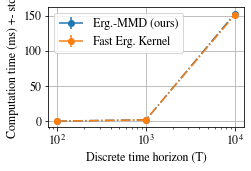

In [30]:
plt.rcParams["font.family"] = "freeserif"
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(3.5,2.2))

plt.errorbar(Ts, np.array(log['emmd']['mean'])*1e3, yerr=np.array(log['emmd']['std'])*1e3, fmt='-.o', label="Erg.-MMD (ours)")
plt.errorbar(Ts, np.array(log['fast_kernel']['mean'])*1e3, yerr=np.array(log['fast_kernel']['std'])*1e3, fmt='-.o', label="Fast Erg. Kernel")
plt.grid()
plt.xscale("log")
plt.xlabel("Discrete time horizon (T)")
plt.ylabel("Computation time (ms) +- std")
plt.legend()
plt.savefig('emmd_time_scale.svg')

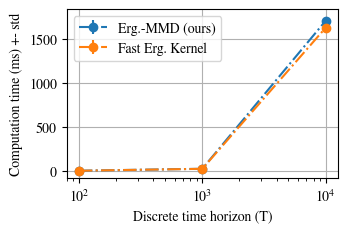

In [122]:
plt.rcParams["font.family"] = "freeserif"
plt.rcParams.update({'font.size': 10})

plt.figure(figsize=(3.5,2.2))

plt.errorbar(Ts, np.array(log['emmd']['mean'])*1e3, yerr=np.array(log['emmd']['std'])*1e3, fmt='-.o', label="Erg.-MMD (ours)")
plt.errorbar(Ts, np.array(log['fast_kernel']['mean'])*1e3, yerr=np.array(log['fast_kernel']['std'])*1e3, fmt='-.o', label="Fast Erg. Kernel")
plt.grid()
plt.xscale("log")
plt.xlabel("Discrete time horizon (T)")
plt.ylabel("Computation time (ms) +- std")
plt.legend()
# plt.savefig('emmd_time_scale.svg')

In [27]:
emmd_loss(params, args)
fast_kernel_loss(params, args)

Array(-2.5518181, dtype=float64)

In [28]:
res = %timeit -o emmd_loss(params, args).block_until_ready()

499 μs ± 105 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [29]:
res = %timeit -o fast_kernel_loss(params, args).block_until_ready()

362 μs ± 9.64 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# points scale analysis

In [25]:
# Sample from the spatial distribution
rng = jax.random.PRNGKey(0)
num_samples = 100
n_dim = 2

key, subkey = jax.random.split(rng, 2)
points = jax.random.uniform(subkey, shape=(num_samples, n_dim))

P_XI = jnp.ones(num_samples)
P_XI_NORM = jnp.sum(P_XI)
P_XI = P_XI/P_XI_NORM

args = {
        'h' : jnp.ones(n_dim), 
        'points' : points, 
        'P_XI' : P_XI,
        'dt' : 0.1,
}

T = 100
X = jnp.linspace(-jnp.ones(n_dim), jnp.ones(n_dim), num=T)

params = {'X': X}

N_samples = [100, 1000, 10_000, 100_000]
log = {
    'emmd' : {'mean' : [], 
            'std' : []},
    'fast_kernel' : {'mean' : [], 
            'std' : []}
}
for N in N_samples: 
    num_samples = N
    n_dim = 2

    key, subkey = jax.random.split(rng, 2)
    points = jax.random.uniform(subkey, shape=(num_samples, n_dim))

    P_XI = jnp.ones(num_samples)
    P_XI_NORM = jnp.sum(P_XI)
    P_XI = P_XI/P_XI_NORM

    args = {
            'h' : jnp.ones(n_dim), 
            'points' : points, 
            'P_XI' : P_XI,
            'dt' : 0.1,
    }

    emmd_loss(params, args)
    fast_kernel_loss(params, args)
    
    res = %timeit -o emmd_loss(params, args).block_until_ready()
    log['emmd']['mean'].append(res.average)
    log['emmd']['std'].append(res.stdev)

    res = %timeit -o fast_kernel_loss(params, args).block_until_ready()
    log['fast_kernel']['mean'].append(res.average)
    log['fast_kernel']['std'].append(res.stdev)

274 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
251 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
463 µs ± 3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
269 µs ± 12.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.03 ms ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
255 µs ± 6.48 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
16.3 ms ± 375 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
247 µs ± 4.72 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


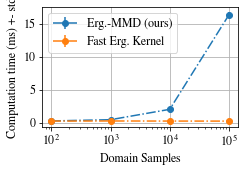

In [27]:
plt.rcParams["font.family"] = "freeserif"
plt.figure(figsize=(3.5,2.2))

# plt.errorbar(N_samples, np.array(log['emmd']['mean'])*1e3, yerr=np.array(log['emmd']['std'])*1e3, fmt='-.o', label="Erg.-MMD CPU (ours)")
plt.errorbar(N_samples, np.array(log['emmd']['mean'])*1e3, yerr=np.array(log['emmd']['std'])*1e3, fmt='-.o', label="Erg.-MMD (ours)")
plt.errorbar(N_samples, np.array(log['fast_kernel']['mean'])*1e3, yerr=np.array(log['fast_kernel']['std'])*1e3, fmt='-.o', label="Fast Erg. Kernel")

plt.grid()
plt.xscale("log")

plt.xlabel("Domain Samples")
plt.ylabel("Computation time (ms) +- std")
plt.legend()
plt.savefig('emmd_sample_scale.svg')

## dimension scaling

In [31]:
# Sample from the spatial distribution
rng = jax.random.PRNGKey(0)
num_samples = 100
n_dim = 2

key, subkey = jax.random.split(rng, 2)
points = jax.random.uniform(subkey, shape=(num_samples, n_dim))

P_XI = jnp.ones(num_samples)
P_XI_NORM = jnp.sum(P_XI)
P_XI = P_XI/P_XI_NORM

args = {
        'h' : jnp.ones(n_dim), 
        'points' : points, 
        'P_XI' : P_XI,
        'dt' : 0.1,
}

T = 100
X = jnp.linspace(-jnp.ones(n_dim), jnp.ones(n_dim), num=T)

params = {'X': X}

n_dims = [2, 10, 100, 1_000]
log = {
    'emmd' : {'mean' : [], 
            'std' : []},
    'fast_kernel' : {'mean' : [], 
            'std' : []}
}
for n_dim in n_dims: 

    key, subkey = jax.random.split(rng, 2)
    points = jax.random.uniform(subkey, shape=(num_samples, n_dim))
    X = jnp.linspace(-jnp.ones(n_dim), jnp.ones(n_dim), num=T)
    params = {'X': X}

    P_XI = jnp.ones(num_samples)
    P_XI_NORM = jnp.sum(P_XI)
    P_XI = P_XI/P_XI_NORM

    args = {
            'h' : jnp.ones(n_dim), 
            'points' : points, 
            'P_XI' : P_XI,
            'dt' : 0.1,
    }

    emmd_loss(params, args)
    fast_kernel_loss(params, args)
    
    res = %timeit -o emmd_loss(params, args).block_until_ready()
    log['emmd']['mean'].append(res.average)
    log['emmd']['std'].append(res.stdev)

    res = %timeit -o fast_kernel_loss(params, args).block_until_ready()
    log['fast_kernel']['mean'].append(res.average)
    log['fast_kernel']['std'].append(res.stdev)

323 µs ± 7.84 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
257 µs ± 3.87 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
471 µs ± 373 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
382 µs ± 1.41 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
2.98 ms ± 56.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.72 ms ± 67 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
67.7 ms ± 69.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
37 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


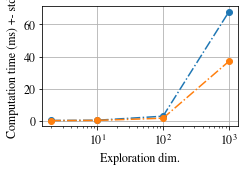

In [32]:
plt.rcParams["font.family"] = "freeserif"
plt.figure(figsize=(3.5,2.2))

plt.errorbar(n_dims, np.array(log['emmd']['mean'])*1e3, yerr=np.array(log['emmd']['std'])*1e3, fmt='-.o')
plt.errorbar(n_dims, np.array(log['fast_kernel']['mean'])*1e3, yerr=np.array(log['fast_kernel']['std'])*1e3, fmt='-.o')

plt.xscale("log")

plt.grid()
plt.xlabel("Exploration dim.")
plt.ylabel("Computation time (ms) +- std")
# plt.legend()
plt.savefig('emmd_state_dim_scale.svg')